#### Importing Modules

In [19]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
import numpy as np
from tqdm import tqdm
from spellchecker import SpellChecker
import spacy
import re
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from typing import List

In [2]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/mbchavez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Setting up Dataset

In [3]:
print("Dataset: ")
language = pd.read_csv("../data/final_annotations.csv")

language.head()

Dataset: 


,word_id,sentence_id,word,label,is_ne,is_spelling_correct
0,45,1,Gusto,FIL,NaN,True
1,46,1,kong,FIL,NaN,True
2,47,1,intindihin,FIL,NaN,True
3,48,1,pero,FIL,NaN,True
4,49,1,hindi,FIL,NaN,True


#### Join Sentences

In [4]:
# Ensure words are strings
language["word"] = language["word"].astype(str)

# Group by sentence_id and combine words
sentences = language.groupby("sentence_id")["word"].apply(lambda x: " ".join(x))

# Map the combined sentence back to the original dataframe
language["sentence"] = language["sentence_id"].map(sentences)


language.head()

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,sentence
0,45,1,Gusto,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...
1,46,1,kong,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...
2,47,1,intindihin,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...
3,48,1,pero,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...
4,49,1,hindi,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...


### Load Sentence Transformer Model

In [5]:
# Load HuggingFace Sentence Transformer Model
model = SentenceTransformer('all-mpnet-base-v2')

#### Convert the Individuals Words into Embeddings

In [6]:
#Generate embeddings for words
language['word_embeddings'] = list(
        model.encode(
            language["word"].tolist(), convert_to_tensor=False, show_progress_bar=True
        )
    )


language['word_embeddings']

Batches: 100%|██████████| 724/724 [01:58<00:00,  6.13it/s]


0        [-0.015572627, 0.05882696, -0.02446479, -0.032...
1        [0.07406978, 0.035357483, -0.027739374, -0.028...
2        [-0.052020285, -0.033879783, -0.04971939, 0.01...
3        [-0.0506149, 0.026319128, -0.0010626945, -0.02...
4        [0.030711884, -0.00059579074, -0.017216908, 0....
                               ...                        
23145    [-0.0093519455, -0.06878516, -0.044534426, -0....
23146    [0.063009344, 0.020623386, 0.0049647195, -0.03...
23147    [0.045219544, 0.008649993, -0.026441053, 0.015...
23148    [-0.021650821, 0.03991619, 0.0031559265, -0.05...
23149    [-0.011788345, 0.061924104, -0.0068219206, 0.0...
Name: word_embeddings, Length: 23150, dtype: object

In [7]:
#Generate embeddings for sentences
language['sentences_embeddings'] = list(
        model.encode(
            language["sentence"].tolist(), convert_to_tensor=False, show_progress_bar=True
        )
    )


language['sentences_embeddings']

Batches: 100%|██████████| 724/724 [17:21<00:00,  1.44s/it] 


0        [-0.009717632, -0.06712133, -0.03707916, 0.028...
1        [-0.009717632, -0.06712133, -0.03707916, 0.028...
2        [-0.009717632, -0.06712133, -0.03707916, 0.028...
3        [-0.009717632, -0.06712133, -0.03707916, 0.028...
4        [-0.009717632, -0.06712133, -0.03707916, 0.028...
                               ...                        
23145    [0.049423873, -0.06350867, 0.02032484, -0.0014...
23146    [0.049423873, -0.06350867, 0.02032484, -0.0014...
23147    [0.049423873, -0.06350867, 0.02032484, -0.0014...
23148    [0.049423873, -0.06350867, 0.02032484, -0.0014...
23149    [0.049423873, -0.06350867, 0.02032484, -0.0014...
Name: sentences_embeddings, Length: 23150, dtype: object

### Extracting Other Features

In [8]:
#Extract Names Entity labels
language['is_ne'].value_counts(dropna=False)
language['is_ne'] = language['is_ne'].fillna('NONE')
language['is_ne']

is_ne = pd.get_dummies(language['is_ne'], prefix='is_ne')

is_ne.head()


,is_ne_ABB,is_ne_ABB_EXPR,is_ne_ABB_NE,is_ne_EXPR,is_ne_NE,is_ne_NONE
0,False,False,False,False,False,True
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,False,False,False,True
4,False,False,False,False,False,True


In [9]:
#Extract Spelling Correctness labels
is_spelling_correct = language["is_spelling_correct"].astype(int).to_numpy().reshape(-1,1)

is_spelling_correct

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], shape=(23150, 1))

In [10]:
def classify_if_is_spelling_correct(token: str) -> int:
    """
    Classifies if a token is spelled correctly.
    Args:
        token: The word token (string).
    Returns:
        is_correct: 1 if spelled correctly, 0 otherwise.
    """
    spell = SpellChecker()

    return 1 if token in spell else 0

In [11]:
classify_if_is_spelling_correct("kasalanan")

0

In [12]:
def classify_if_is_ne(token: str) -> str:
    """
    Classifies if a token is a named entity.
    Args:
        token: The word token (string).
    Returns:
        "ABB_NE" -> abbreviation named entity
        "NE" -> named entity
        "NONE" -> neither
        "EXPR" -> expression
    """
    name_checker = spacy.load("xx_ent_wiki_sm")
    abbr_pattern = r'^([A-Z0-9]\.?)+$'

    doc = name_checker(token)

    is_ne = bool(doc[0].ent_type_) 
    is_abbr = bool(re.match(abbr_pattern, token))

    if is_ne and is_abbr:
        return "ABB_NE"
    elif is_ne:
        return "NE"
    elif is_abbr:
        return "ABB"
    else:
        return "NONE"

In [13]:
classify_if_is_ne("January")

'NONE'

#### Orthographic Features

In [14]:
def get_ortographic_features(token: str):
    """
    Extract orthographic features for a given token.
    Args:
        token: The word token (string).
    Returns:
        features: A numpy array of orthographic features.
    """
    features = []


    return features

#### Training the Model From the Extracted Featurse

In [32]:
#Prepare the Features and Labels to Split the Data
# Prepare Word and Sentence Embeddings
word_embeddings = np.vstack(language["word_embeddings"])
sentences_embeddings = np.vstack(language["sentences_embeddings"])

# X = np.hstack([np.vstack(language["embeddings"]), is_spelling_correct, is_ne.values])
# X = np.hstack([np.vstack(language["word_embeddings"]), is_ne.values])
# X = np.hstack([np.vstack(language["word_embeddings"]), is_ne.values])
# X = np.hstack([word_embeddings, sentences_embeddings])

X = np.hstack([word_embeddings])
y = language["label"]

# 70% Train, 15% Validation, 15% Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 30% of 30% = 15% Validation, 15% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 16205, Validation: 3472, Test: 3473


In [ ]:
print("Normalize X Data...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Apply PCA...")
pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

print(f"PCA retained {np.sum(pca.explained_variance_ratio_):.2%} of variance")

print("Training the model...")
clf = RandomForestClassifier(n_estimators=300, random_state=42,verbose=1)
clf.fit(X_train, y_train)

Normalize X Data...
Apply PCA...
PCA retained 95.03% of variance
Training the model...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.4s


#### Visualize the Trees from the Random Forest

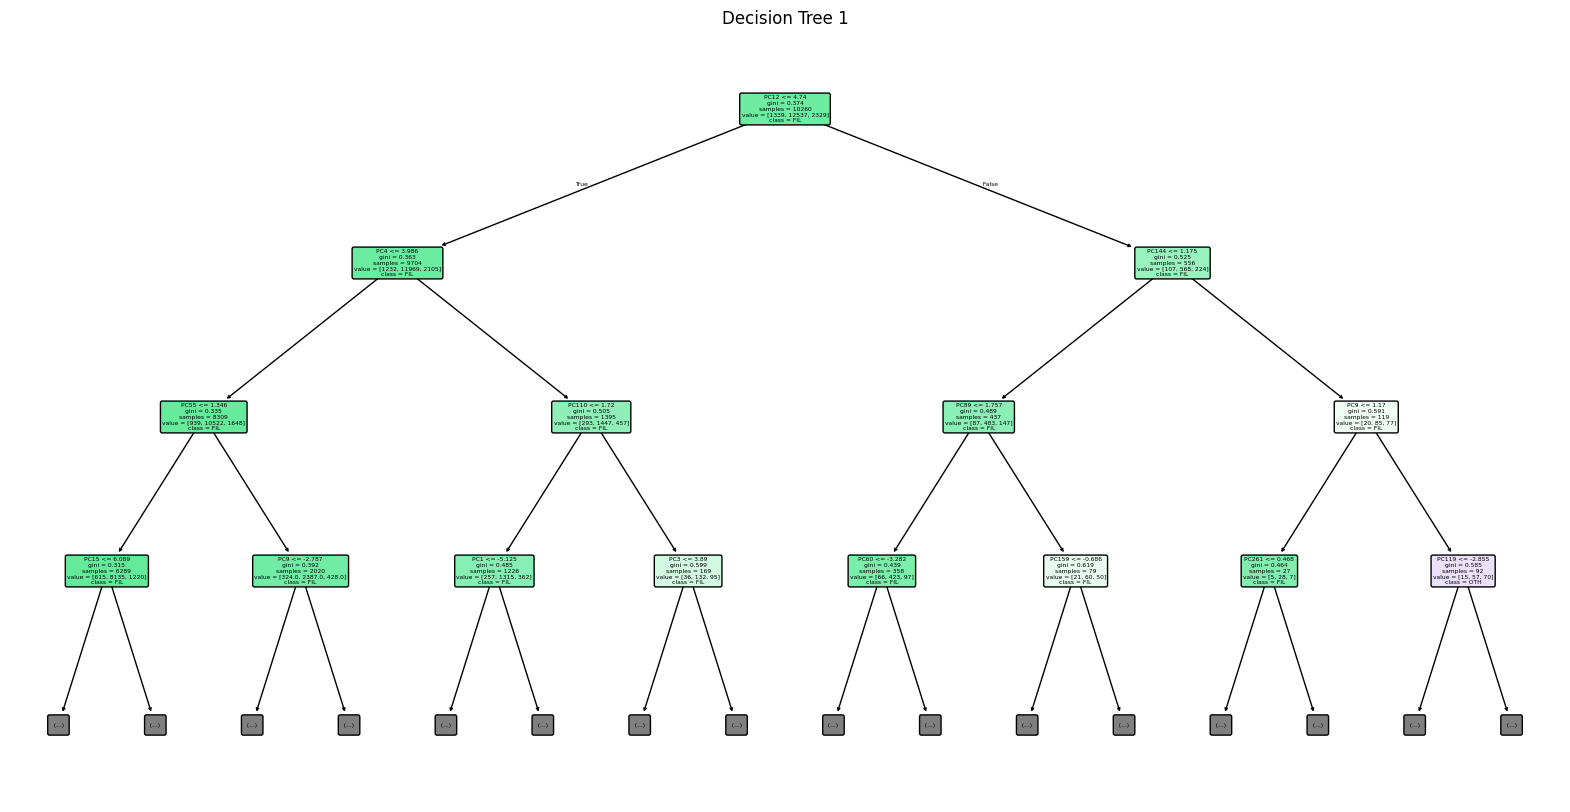

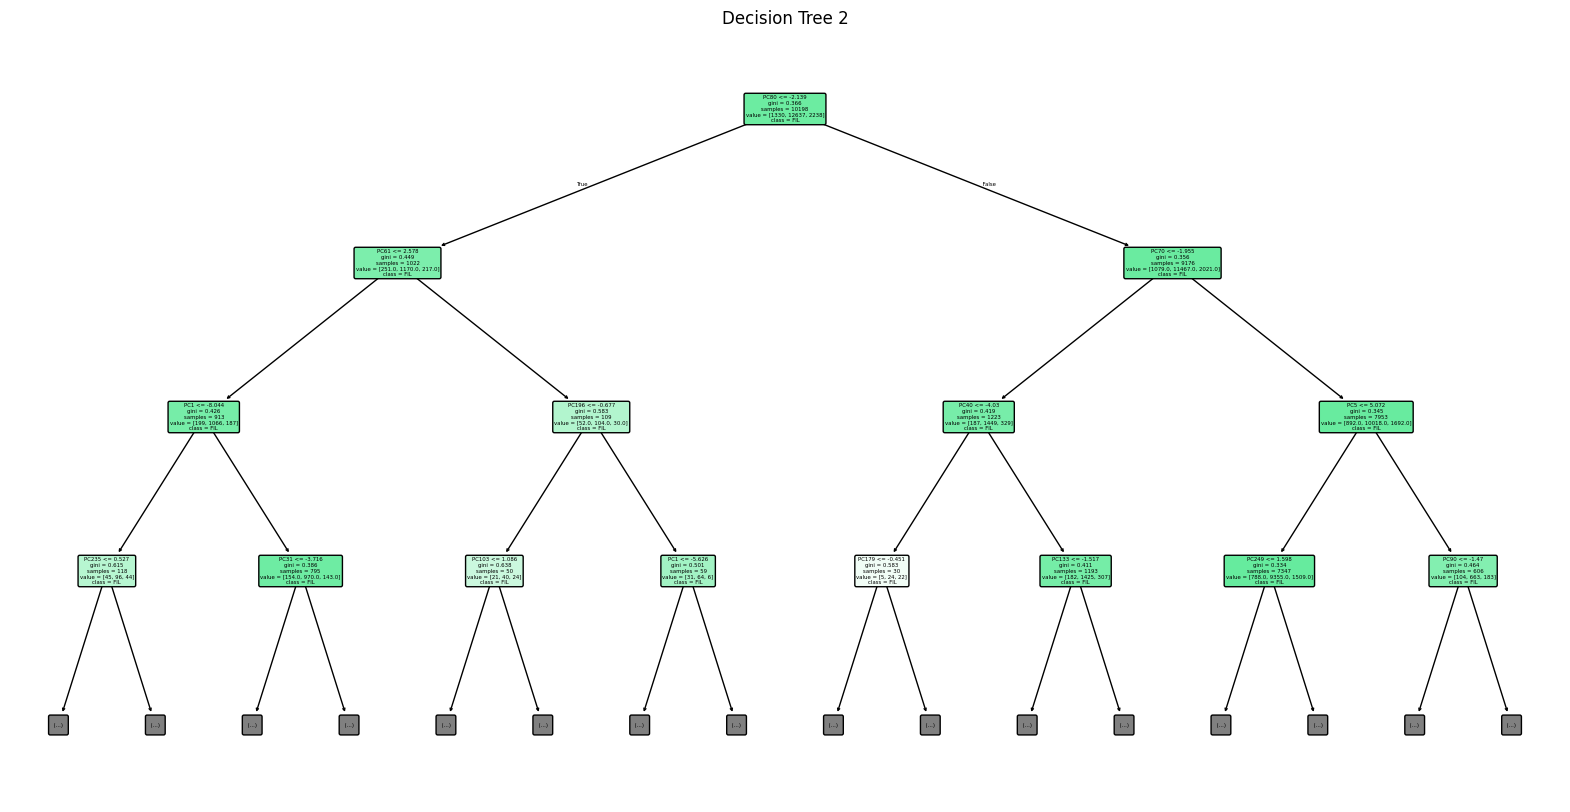

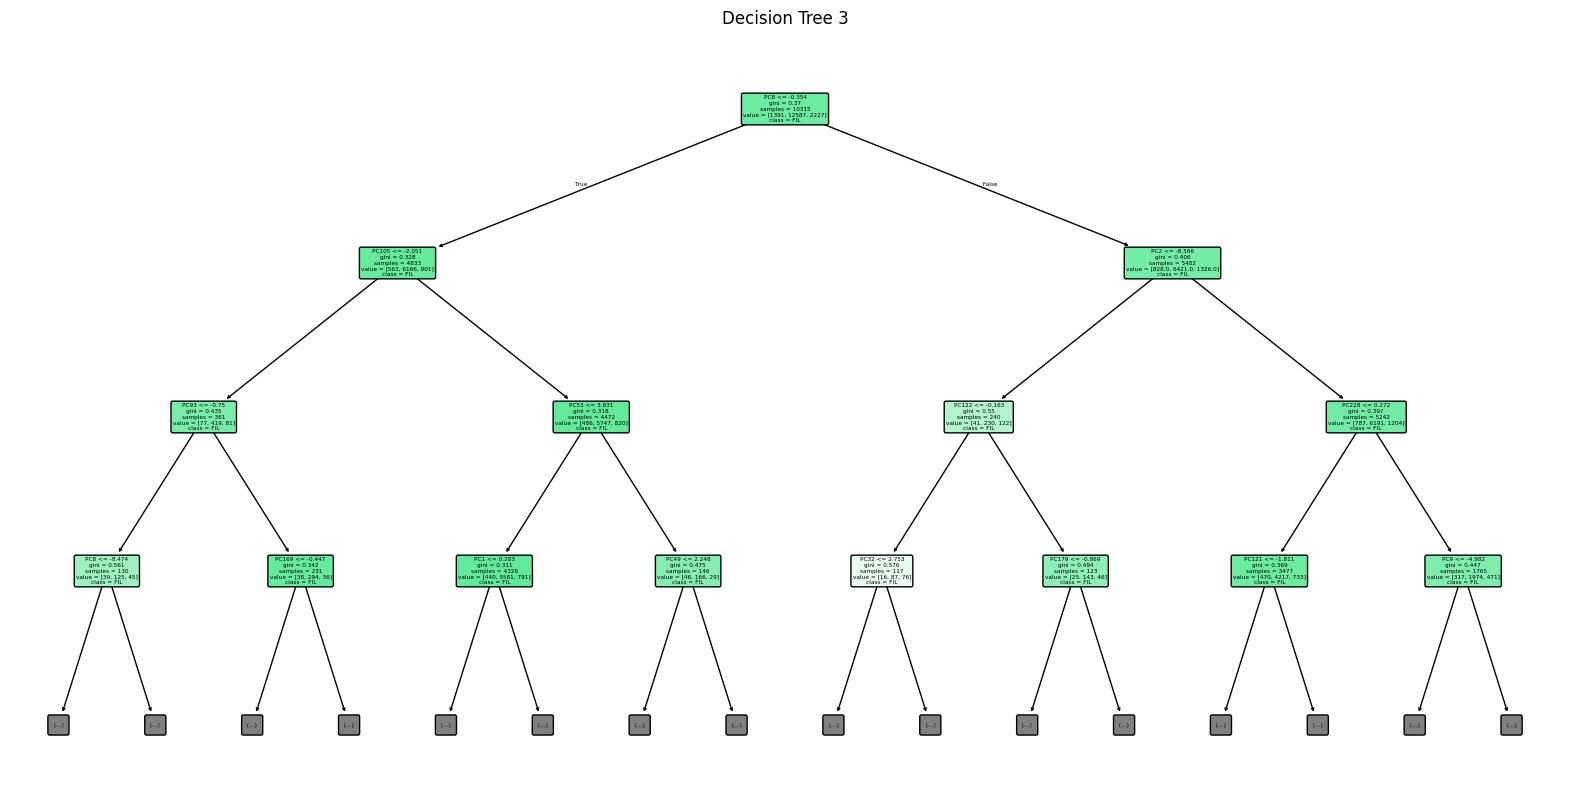

In [27]:
# Pick a few trees from your forest (since 300 is too many)
n_trees_to_plot = 3
for i in range(n_trees_to_plot):
    estimator = clf.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(
        estimator,
        filled=True,
        rounded=True,
        max_depth=3,  # limit depth for readability
        feature_names=[f"PC{i+1}" for i in range(X_train.shape[1])],
        class_names=[str(c) for c in clf.classes_],
    )
    plt.title(f"Decision Tree {i+1}")
    plt.show()

In [28]:
# Evaluate Model
print("Evaluating model...\n")
y_val_pred = clf.predict(X_val)
print("Validation Performance:")
print(classification_report(y_val, y_val_pred))

y_test_pred = clf.predict(X_test)
print("\nTest Performance:")
print(classification_report(y_test, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Evaluating model...



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished


Validation Performance:
              precision    recall  f1-score   support

         ENG       0.17      0.06      0.08       288
         FIL       0.78      0.93      0.85      2692
         OTH       0.19      0.06      0.09       492

    accuracy                           0.74      3472
   macro avg       0.38      0.35      0.34      3472
weighted avg       0.65      0.74      0.68      3472



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished



Test Performance:
              precision    recall  f1-score   support

         ENG       0.15      0.05      0.07       288
         FIL       0.78      0.94      0.85      2693
         OTH       0.16      0.04      0.06       492

    accuracy                           0.74      3473
   macro avg       0.36      0.34      0.33      3473
weighted avg       0.64      0.74      0.68      3473

Test Accuracy: 0.7397


In [ ]:
def tag_language(tokens: List[str]) -> List[str]:
    """
    Tags each token in the input list with its predicted language.

    Args:
        tokens: List of word tokens (strings).

    Returns:
        tags: List of predicted tags ("ENG", "FIL", or "OTH"), one per token.
    """
    # Generate Embeddings
    embedder = SentenceTransformer("all-mpnet-base-v2")

    # Setup Named Entity Categories
    ne_categories = ["ABB", "ABB_EXPR", "ABB_NE", "EXPR", "NE", "NONE"]

    features = []

    for token in tokens:
        # Token embedding
        token_embedding = embedder.encode([token])[0]

        # Classify if token is a Named Entity
        ne_token = classify_if_is_ne(token)

        # Create one-hot encoding for NE feature
        is_ne_onehot = np.zeros((1, len(ne_categories)))
        if ne_token in ne_categories:
            is_ne_onehot[0, ne_categories.index(ne_token)] = 1

        # Combine embeddings (same setup as main function)
        combined = np.hstack([token_embedding])
        features.append(combined)

    # Stack all token feature vectors
    X = np.vstack(features)

    # Apply PCA
    X = pca.transform(X)

    # Predict tags
    predicted = clf.predict(X)

    return [str(tag) for tag in predicted]

In [31]:
from nltk import word_tokenize
nltk.download("punkt") 
tokens = word_tokenize("Ginamit pa yung anak ni kuya kim para sa agenda nila. Pag napasa yan bawal ng batikusin yung mga corrupt na pulitiko. Lol")
tags = tag_language(tokens)
print("\n-----\n")
print("Tokens:", tokens)
print("\n-----\n")
print("Tags:", tags)
print("\n-----\n")

[nltk_data] Downloading package punkt to /home/mbchavez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ValueError: X has 1536 features, but PCA is expecting 768 features as input.